In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**1.1 Simple picture to explain Diabetic Retinopathy
How do we know that a patient have diabetic retinopahy? There are at least 5 things to spot on. Image credit https://www.eyeops.com/**

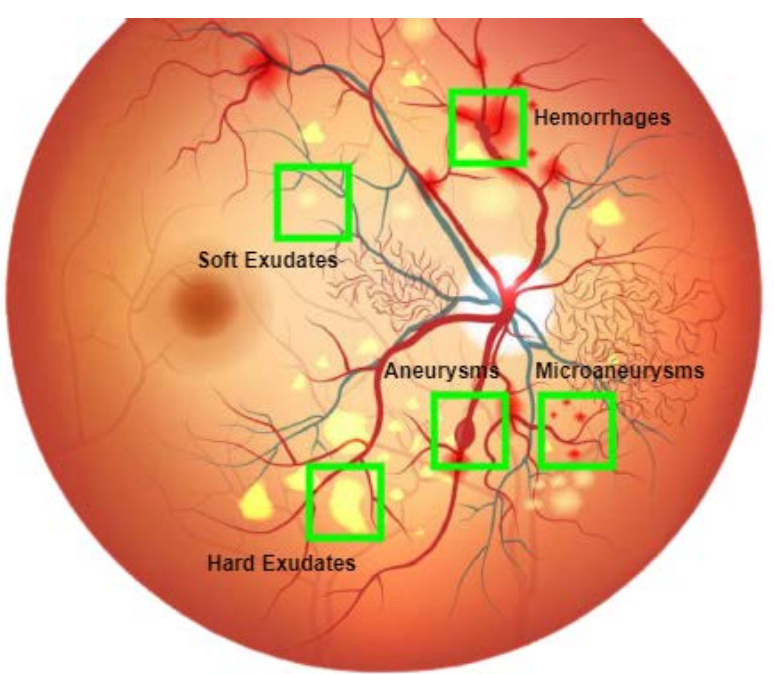


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input,InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.optimizers import RMSprop,Adam
import gc

In [4]:
#2019 data
'''import cv2
import glob
from tqdm import tqdm
files= glob.glob("../input/aptos2019-blindness-detection/train_images/*.png")
for i in tqdm(range(len(files))):
    img = cv2.imread(files[i])
    green=img[:,:,1]
    clache= cv2.createCLAHE(clipLimit=3.0)
    clache_img= clache.apply(green) 
    median_img= cv2.medianBlur(clache_img,5)
    

    resize_img=cv2.resize(median_img,(256,256))
    

    #canny_img= cv2.Canny(resize_img,75,200)

    
    cv2.imwrite("./"+os.path.basename(files[i]), resize_img)'''

'import cv2\nimport glob\nfrom tqdm import tqdm\nfiles= glob.glob("../input/aptos2019-blindness-detection/train_images/*.png")\nfor i in tqdm(range(len(files))):\n    img = cv2.imread(files[i])\n    green=img[:,:,1]\n    clache= cv2.createCLAHE(clipLimit=3.0)\n    clache_img= clache.apply(green) \n    median_img= cv2.medianBlur(clache_img,5)\n    \n\n    resize_img=cv2.resize(median_img,(256,256))\n    \n\n    #canny_img= cv2.Canny(resize_img,75,200)\n\n    \n    cv2.imwrite("./"+os.path.basename(files[i]), resize_img)'

In [5]:
base_image_dir= os.path.join("..","input", "aptos2019-blindness-detection")
print(base_image_dir)
retina_df2019 = pd.read_csv(os.path.join(base_image_dir, "train.csv"))
#retina_df["PatientId"]= retina_df["id_code"].map(lambda x: x.split("_")[0])
retina_df2019['path'] = retina_df2019['id_code'].map(lambda x: os.path.join("../input/aptos2019-blindness-detection/train_images",'{}.png'.format(x)))
retina_df2019["exists"]= retina_df2019["path"].map(os.path.exists)
print(retina_df2019["exists"].sum(),"found of",retina_df2019.shape[0], "total")
retina_df2019.dropna(inplace= True)
retina_df2019= retina_df2019[retina_df2019["exists"]]
retina_df=retina_df2019

../input/aptos2019-blindness-detection
3662 found of 3662 total


In [6]:
retina_df

id_code  diagnosis  \
0     000c1434d8d7          2   
1     001639a390f0          4   
2     0024cdab0c1e          1   
3     002c21358ce6          0   
4     005b95c28852          0   
...            ...        ...   
3657  ffa47f6a7bf4          2   
3658  ffc04fed30e6          0   
3659  ffcf7b45f213          2   
3660  ffd97f8cd5aa          0   
3661  ffec9a18a3ce          2   

                                                   path  exists  
0     ../input/aptos2019-blindness-detection/train_i...    True  
1     ../input/aptos2019-blindness-detection/train_i...    True  
2     ../input/aptos2019-blindness-detection/train_i...    True  
3     ../input/aptos2019-blindness-detection/train_i...    True  
4     ../input/aptos2019-blindness-detection/train_i...    True  
...                                                 ...     ...  
3657  ../input/aptos2019-blindness-detection/train_i...    True  
3658  ../input/aptos2019-blindness-detection/train_i...    True  
3659  ../input/aptos2019-blindness-detection/train_i...    True  
3660  ../input/aptos2019-blindness-detection/train_i...    True  
3661  ../input/aptos2019-blindness-detection/train_i...    True  

[3662 rows x 4 columns]

**Examine the distribution of eye and severity**

array([[<AxesSubplot:title={'center':'diagnosis'}>]], dtype=object)

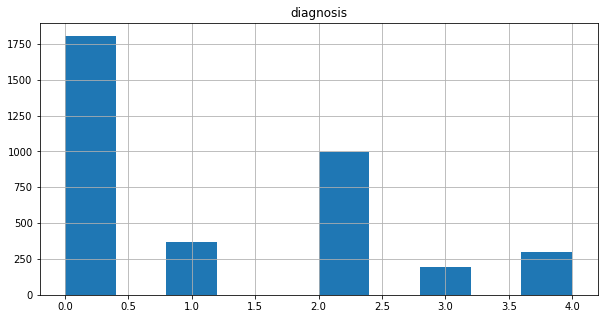

In [7]:
retina_df[["diagnosis"]].hist(figsize=(10,5))

In [8]:
import glob

In [9]:
SEED = 7
np.random.seed(SEED)
#set_random_seed(SEED)
dir_path = "/kaggle/input/"
IMG_DIM = 128
BATCH_SIZE = 8
CHANNEL_SIZE = 3

TRAIN_DIR = 'train_images'
TEST_DIR = 'test_images'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
NUM_CLASSS = 5

In [10]:
ROOT_PATH = '/kaggle/input/aptos2019-blindness-detection'
TRAIN_PATH = '/kaggle/input/aptos2019-blindness-detection/' + TRAIN_DIR 
TEST_PATH = '/kaggle/input/aptos2019-blindness-detection/' + TEST_DIR 
dir_path = ROOT_PATH + '/'

In [11]:
def draw_img(imgs, target_dir, class_label='0'):
    for row in enumerate(imgs.iterrows()):
        name = row[1][1]['id_code'] + '.png'
        print(name)
        plt.figure(figsize=(15,10))
        img = plt.imread(dir_path + target_dir + '/' + name)
        plt.imshow(img)
        plt.title(class_label)
        plt.show()
        del img
        gc.collect

de6210f88536.png


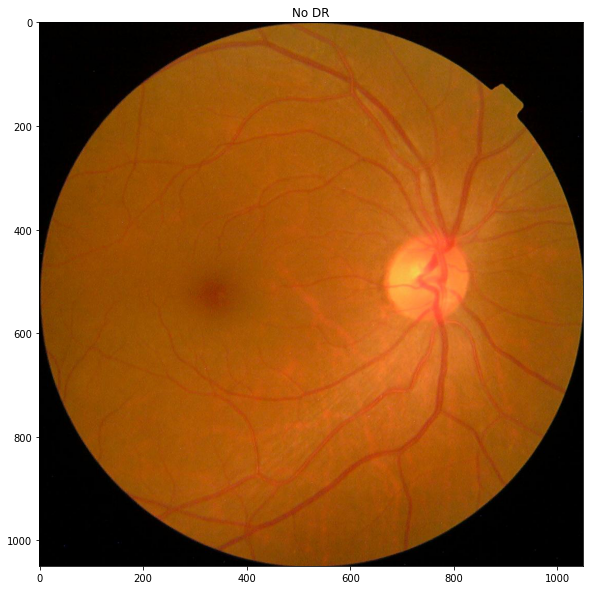

In [12]:
# Showing the class 0 image randomly
CLASS_ID = 0
draw_img(retina_df[retina_df.diagnosis == CLASS_ID].sample(n=1), 'train_images', CLASSS[CLASS_ID])

059bc89df7f4.png


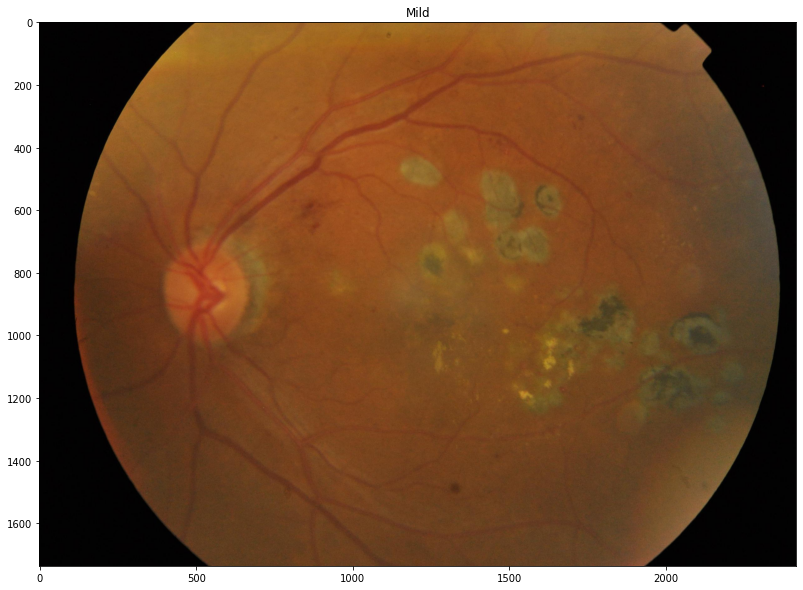

In [13]:
# Showing the class 1 image randomly
CLASS_ID = 1
draw_img(retina_df[retina_df.diagnosis == CLASS_ID].sample(n=1), 'train_images', CLASSS[CLASS_ID])

8421107255ae.png


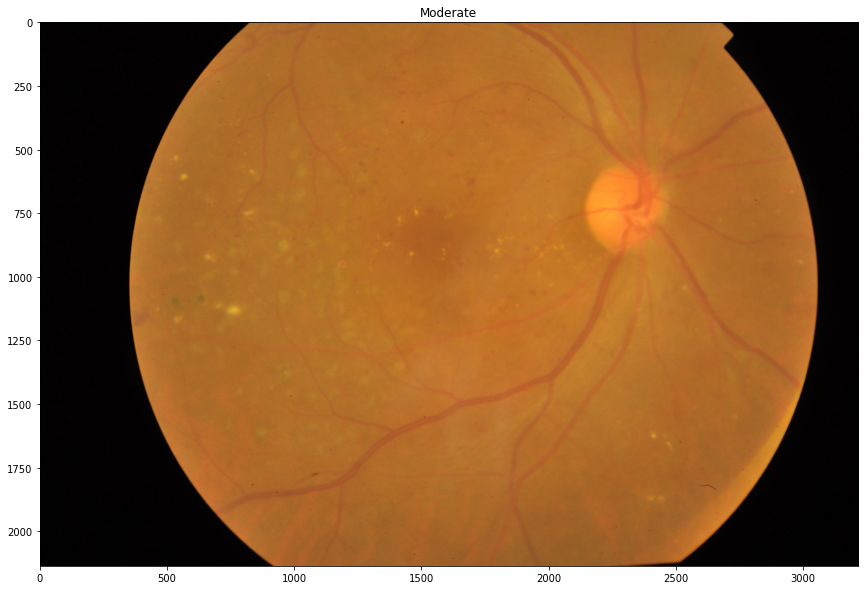

In [14]:
# Showing the class 1 image randomly
CLASS_ID = 2
draw_img(retina_df[retina_df.diagnosis == CLASS_ID].sample(n=1), 'train_images', CLASSS[CLASS_ID])

b191ba0a2b12.png


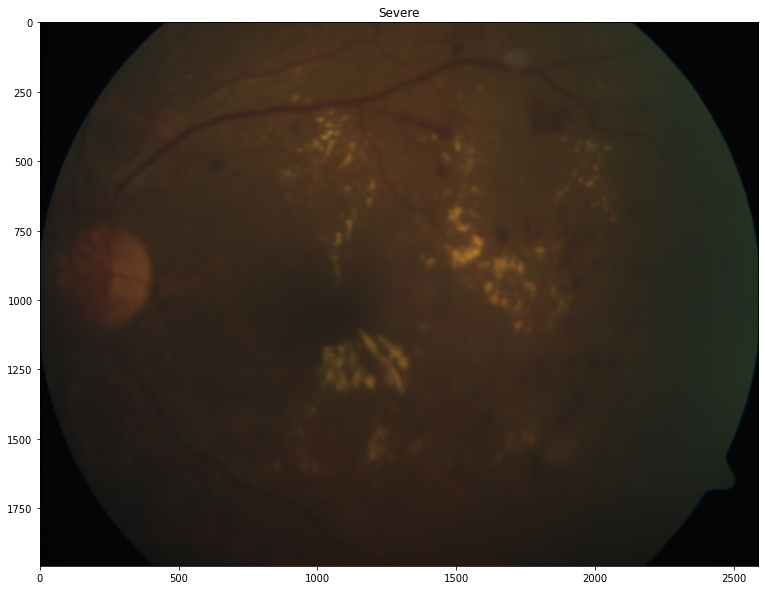

In [15]:
# Showing the class 1 image randomly
CLASS_ID = 3
draw_img(retina_df[retina_df.diagnosis == CLASS_ID].sample(n=1), 'train_images', CLASSS[CLASS_ID])

1638404f385c.png


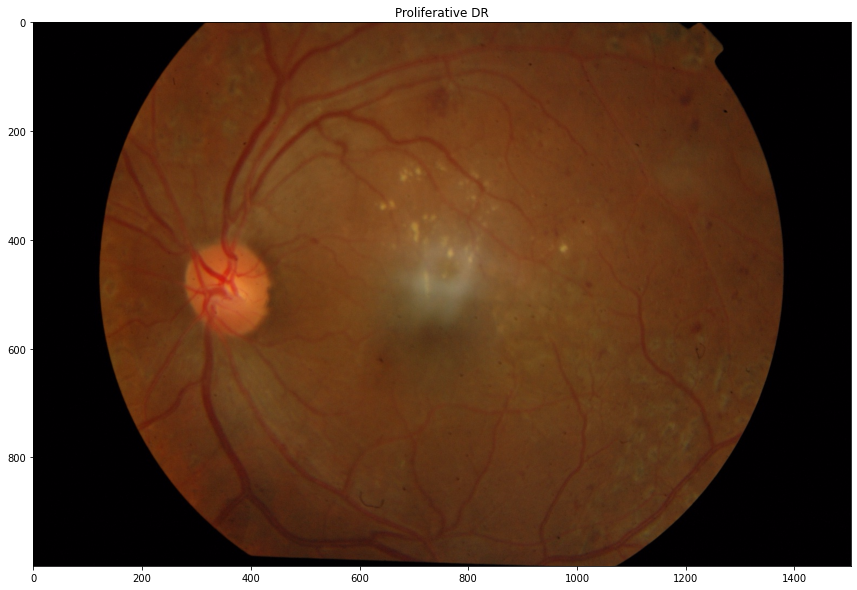

In [16]:
# Showing the class 1 image randomly
CLASS_ID = 4
draw_img(retina_df[retina_df.diagnosis == CLASS_ID].sample(n=1), 'train_images', CLASSS[CLASS_ID])

In [17]:
x = retina_df['id_code']
y = retina_df['diagnosis']

#x, y = shuffle(x, y, random_state=SEED)

CPU times: user 4.99 s, sys: 176 ms, total: 5.16 s
Wall time: 5.4 s


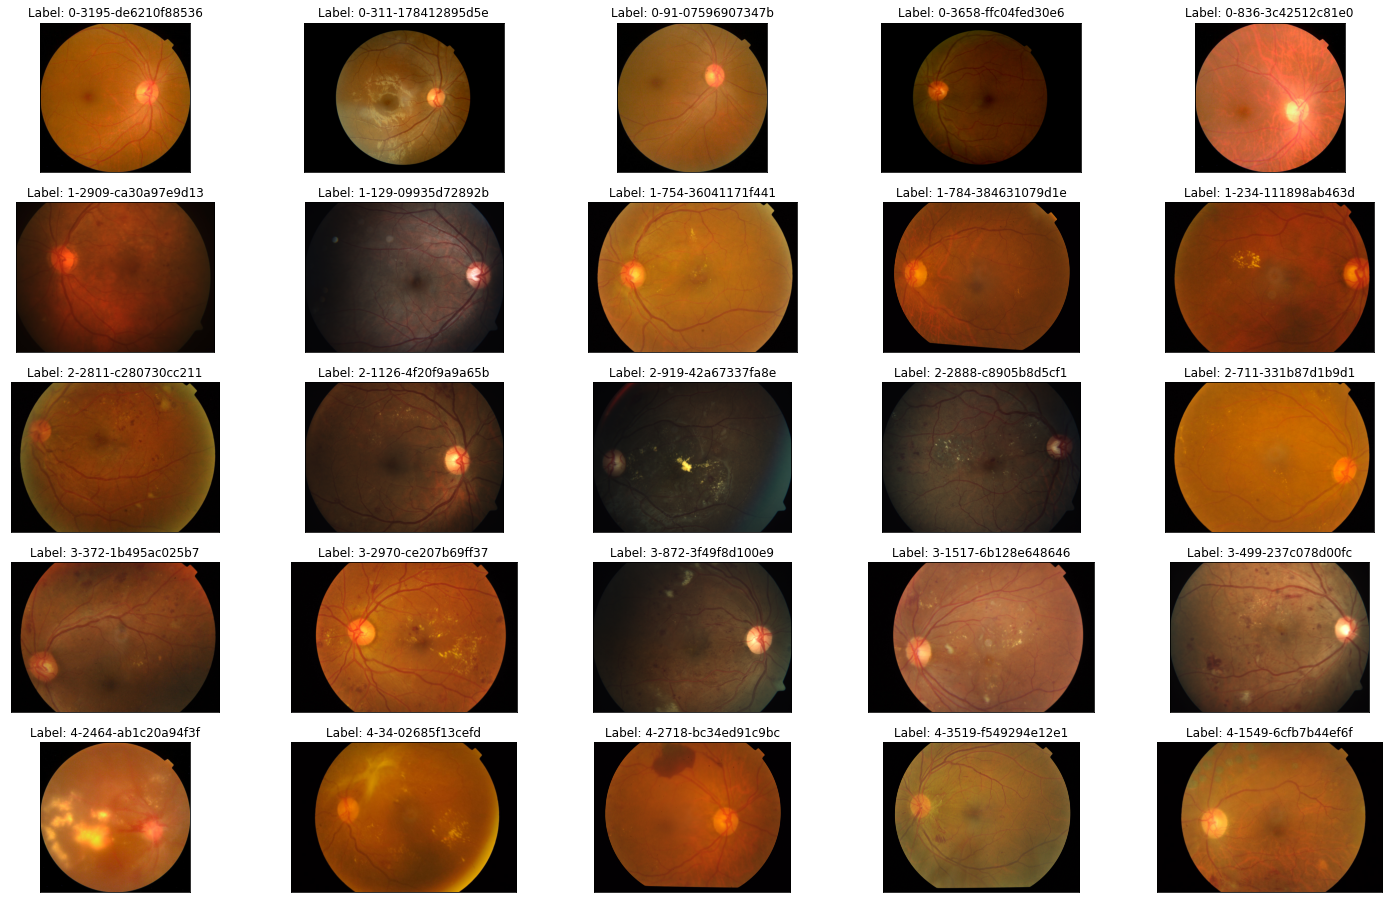

In [18]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 5 images from each class
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(retina_df.loc[retina_df['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# **Preprocess/Data Preparation**

In [19]:
from tqdm import tqdm
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in tqdm(data_frame.iterrows()):  
        Y[index,entry[labelcol]] = 1
        img = cv2.imread(entry[filenamecol])
        green=img[:,:,1]
        clache= cv2.createCLAHE(clipLimit=3.0)
        clache_img= clache.apply(green) 
        median_img= cv2.medianBlur(clache_img,5)
        resize_img=cv2.resize(median_img,(256,256))
        layer=cv2.merge((resize_img,resize_img,resize_img))
        X[index,:] =layer
        X[index,:] = X[index,:] /255.0
    return X,Y

# **Split Data into Training and Validation**

In [20]:
from sklearn.model_selection import train_test_split
train_df,val_df= train_test_split(retina_df,
                                    random_state = 42,
                                    shuffle= True,
                                    test_size=0.30)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [21]:
del retina_df
gc.collect()

37

In [22]:
batch_size = 32
img_size = 256
X_train,Y_train = load_raw_images_df(train_df,"path","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"path","diagnosis",img_size,5)
del train_df
del val_df
gc.collect()


2563it [05:39,  7.54it/s]
1099it [02:30,  7.31it/s]


76

# **After Preprocessing **

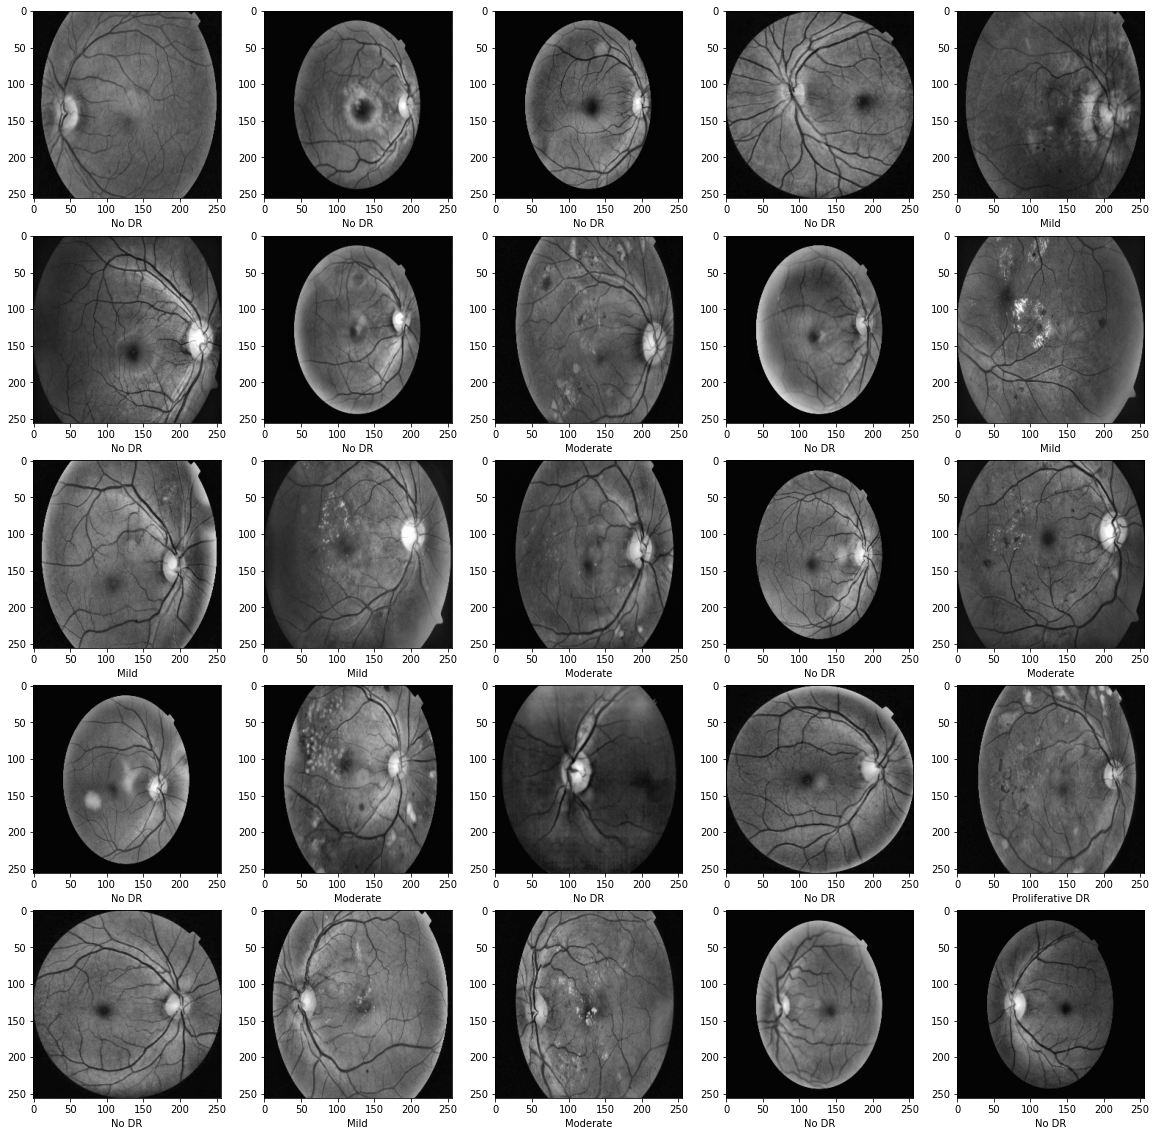

In [23]:
#files= glob.glob("../input/aptos2019-blindness-detection/train_images/*.png")

plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i+25])
    #plt.xlabel("print()")
    plt.xlabel('{}'.format(CLASSS[np.argmax(Y_train[i+25])]))

# **Model**

In [24]:
path= "../input/d/madmaxliu/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model=InceptionV3(weights="../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",input_shape=(256,256,3),include_top=False)
for layer in pre_trained_model.layers:
    layer.trainable=False
last_layer=pre_trained_model.get_layer("mixed7")
last_output= last_layer.output
x= layers.Flatten()(last_output)
x=layers.Dense(1024,activation="relu")(x)
x=layers.Dropout(0.5)(x)
x= layers.Dense(5,activation="softmax")(x)
model= Model(pre_trained_model.input,x)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
model.compile(optimizer=Adam(lr=0.00005),loss = "categorical_crossentropy" ,metrics = ["accuracy"])

In [27]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,  
            fill_mode='constant', 
            cval=0.,  
            horizontal_flip=True,  
            vertical_flip=True)



In [28]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
mc= ModelCheckpoint(filepath= "./best_model.h5",
                    monitor="accuracy",
                    verbose=1,
                    save_best_only=True)
es=EarlyStopping(monitor="accuracy",
                 min_delta=0.01,
                 patience=50,
                 verbose=1)
cb=[mc,es]

In [29]:
EPOCHS = 10
history=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), 
                        validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]/32,
                            callbacks=cb, epochs=EPOCHS)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
80/80 [==============================] - 46s 456ms/step - loss: 1.2313 - accuracy: 0.5607 - val_loss: 0.7698 - val_accuracy: 0.7116

Epoch 00001: accuracy improved from -inf to 0.64963, saving model to ./best_model.h5
Epoch 2/10
80/80 [==============================] - 34s 424ms/step - loss: 0.7558 - accuracy: 0.7184 - val_loss: 0.7036 - val_accuracy: 0.7252

Epoch 00002: accuracy improved from 0.64963 to 0.71713, saving model to ./best_model.h5
Epoch 3/10
80/80 [==============================] - 34s 422ms/step - loss: 0.6890 - accuracy: 0.7410 - val_loss: 0.6934 - val_accuracy: 0.7389

Epoch 00003: accuracy improved from 0.71713 to 0.74600, saving model to ./best_model.h5
Epoch 4/10
80/80 [==============================] - 33s 418ms/step - loss: 0.6883 - accuracy: 0.7354 - val_loss: 0.6457 - val_accuracy: 0.7452

Epoch 00004: accuracy did not improve from 0.74600
Epoch 5/10
80/80 [==============================] - 34s 419ms/step - loss: 0.6737 - accuracy: 0.7277 - val_loss:

In [30]:
from tensorflow.keras.models import load_model
model= load_model("./best_model.h5")
h= history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

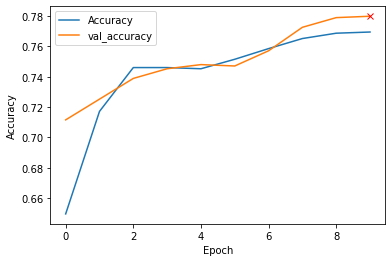

In [31]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Accuracy', 'val_accuracy'])
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r",
         label="best model")
plt.show()

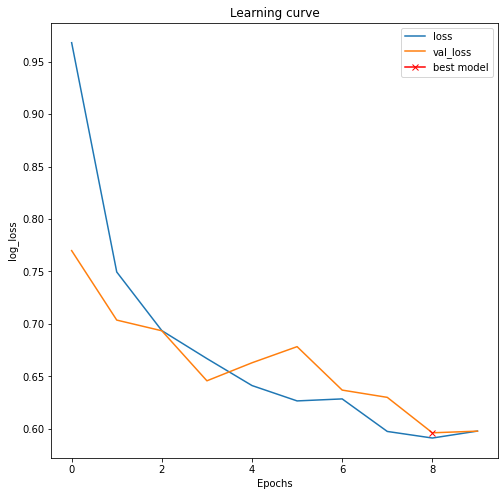

In [34]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [35]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(X_val, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(Y_val, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

35/35 [==============================] - 3s 55ms/step
Accuracy on Test Data: 0.78%
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       540
           1       0.67      0.24      0.36        98
           2       0.63      0.89      0.73       302
           3       0.53      0.15      0.23        55
           4       0.74      0.24      0.36       104

    accuracy                           0.78      1099
   macro avg       0.69      0.50      0.53      1099
weighted avg       0.77      0.78      0.74      1099



<AxesSubplot:>

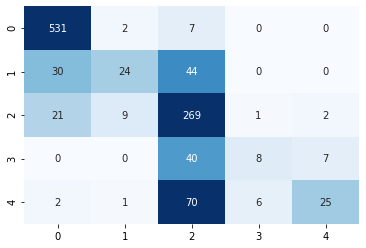

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

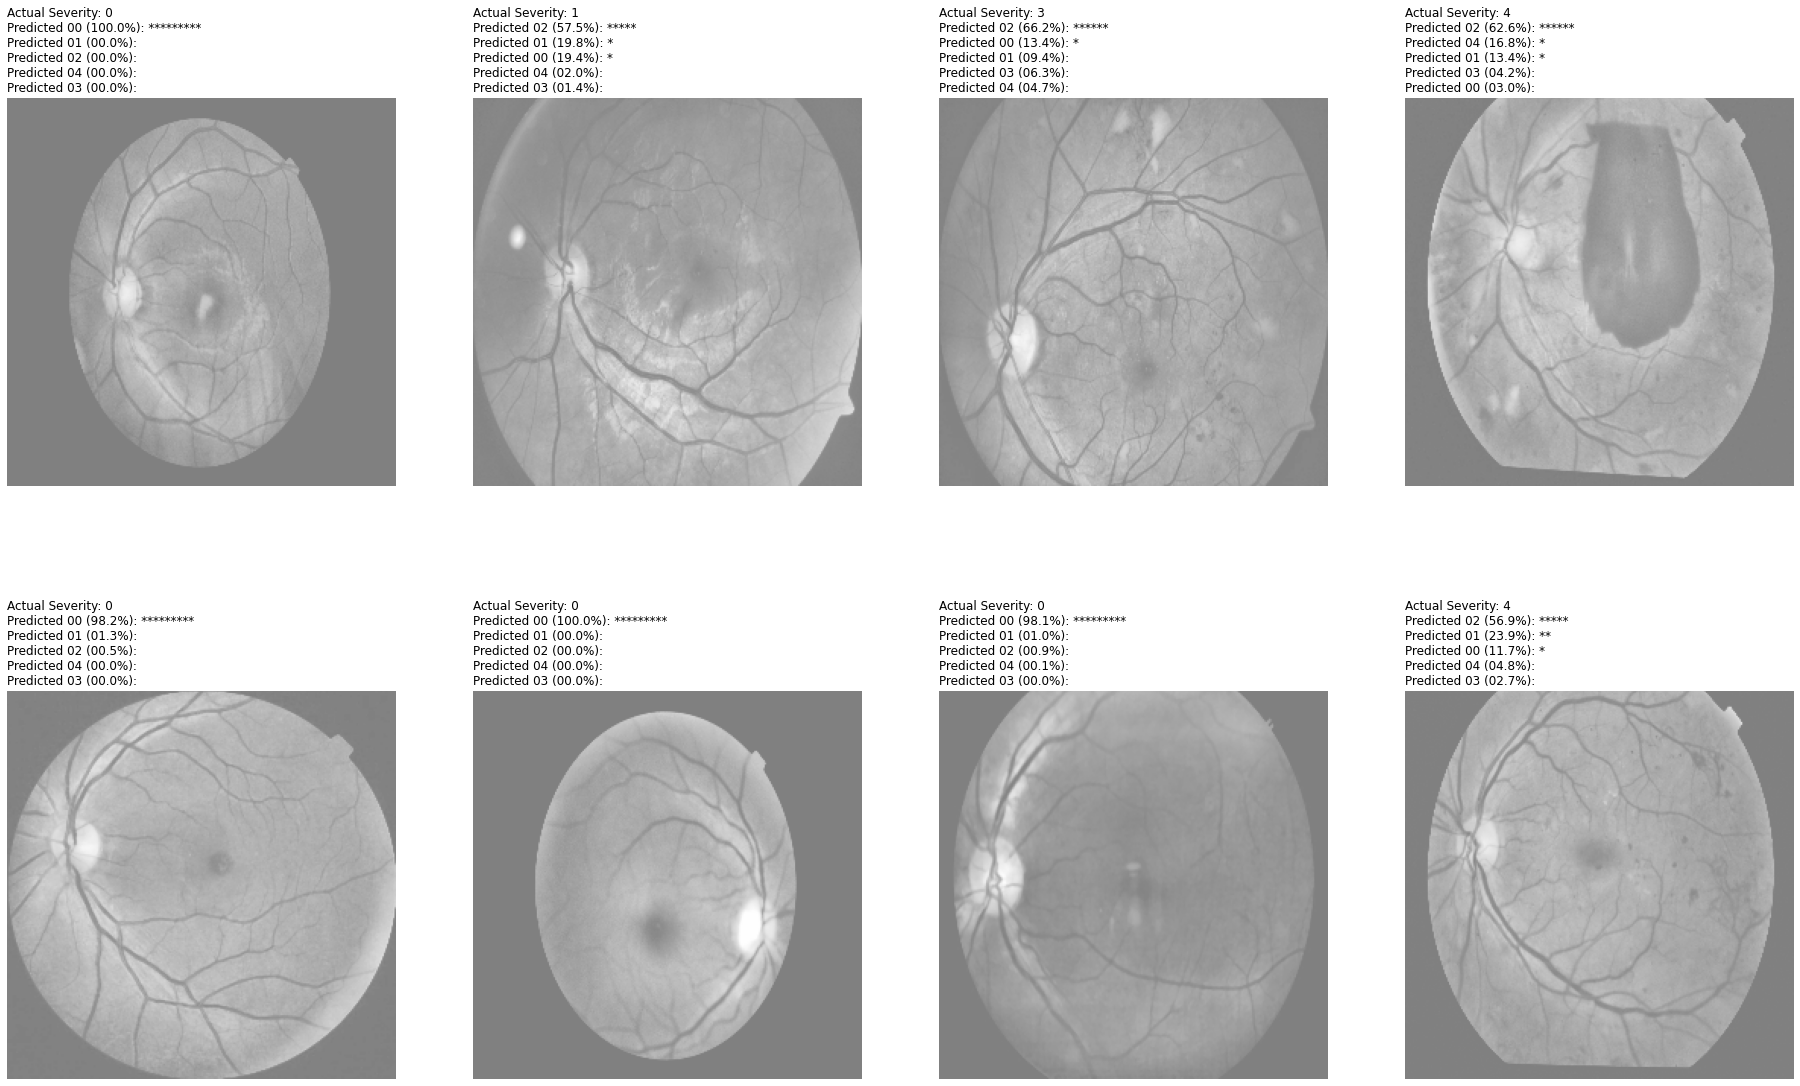

In [39]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(X_val[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [40]:
y_pred=np.empty(X_val.shape[0])
y_true=np.empty(X_val.shape[0])
for index,val in enumerate(model.predict(X_val)):
    y_pred[index]= np.argmax(val)
    

**Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec**

In [41]:
test_data=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

In [42]:
test_data['filename'] = test_data['id_code'].map(lambda x: x+".png")

In [43]:
test_data

id_code          filename
0     0005cfc8afb6  0005cfc8afb6.png
1     003f0afdcd15  003f0afdcd15.png
2     006efc72b638  006efc72b638.png
3     00836aaacf06  00836aaacf06.png
4     009245722fa4  009245722fa4.png
...            ...               ...
1923  ff2fd94448de  ff2fd94448de.png
1924  ff4c945d9b17  ff4c945d9b17.png
1925  ff64897ac0d8  ff64897ac0d8.png
1926  ffa73465b705  ffa73465b705.png
1927  ffdc2152d455  ffdc2152d455.png

[1928 rows x 2 columns]

In [47]:
test_gen=ImageDataGenerator(rescale=1./255)
test_generator=test_gen.flow_from_dataframe(

                                dataframe=test_data,
                                directory="../input/aptos2019-blindness-detection/test_images",
                                x_col="filename",
                                y_col=None,
                                
                                target_size=(256,256),
                                color_mode="rgb",
                                batch_size=1,
                                shuffle=False,
                                class_mode=None)

Found 1928 validated image filenames.


In [48]:
predictions=model.predict_generator(test_generator,steps=len(test_generator.filenames))

In [49]:
filenames=test_generator.filenames
results=pd.DataFrame(
{"id_code":filenames,
"diagnosis":np.argmax(predictions,axis=1),
})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

<AxesSubplot:>

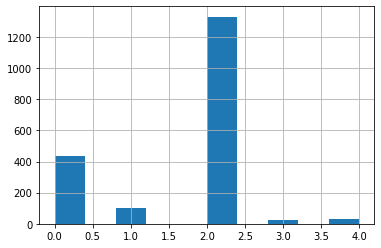

In [50]:
results.diagnosis.hist()

In [51]:
results.diagnosis.unique()

array([1, 2, 0, 3, 4])

In [52]:
output= pd.read_csv("./submission.csv")

In [53]:
output

id_code  diagnosis
0     0005cfc8afb6          1
1     003f0afdcd15          2
2     006efc72b638          2
3     00836aaacf06          2
4     009245722fa4          2
...            ...        ...
1923  ff2fd94448de          0
1924  ff4c945d9b17          2
1925  ff64897ac0d8          2
1926  ffa73465b705          4
1927  ffdc2152d455          0

[1928 rows x 2 columns]

In [ ]:
img= cv2.imread("../input/temporarty/00a8624548a9.jpg")

In [ ]:
resize_img=cv2.resize(img,(256,256))

In [ ]:
plt.imshow(img)

In [ ]:
temp_img=img_to_array(img)

In [ ]:
temp_img.resize(1,256,256,3)

In [ ]:
np.argmax(model.predict(temp_img))